# Sales Forecast

## 1. Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import signal
from scipy.stats import hmean
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pingouin as pg
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.metrics import mean_absolute_error
import warnings

C:\Users\enart\Anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.9, the latest is 0.3.10.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 2000)

## 2. Data Import and Exploartion

In [3]:
sales_train_validation = pd.read_csv('datasets/sales_train_validation.csv')

In [4]:
sales = sales_train_validation.copy()

In [5]:
print("Basic information about the data:")
print(sales.info())

print('\n Dimension of the data (rows,columns):')
print(sales.shape)

Basic information about the data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1919 entries, id to d_1913
dtypes: int64(1913), object(6)
memory usage: 446.4+ MB
None

 Dimension of the data (rows,columns):
(30490, 1919)


In [6]:
#View of first 5 rows in the data
sales.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  d_5  d_6  d_7  d_8  d_9  d_10  d_11  d_12  \
0       CA    0    0    0    0    0    0    0    0    0     0     0     0   
1       CA    0    0    0    0    0    0    0    0    0     0     0     0   
2       CA    0    0    0    0    0    0    0    0    0     0     0     0   
3       CA    0    0    0    0    0    0    0    0    0     0     0     0   
4       CA    0    0    0    0    0    0    0    0    0     0     0     0   

   d_13  d_14  d_15  d_16  d_17  d_18  d_19  d_20  d_21  d_22  d_23  d_24  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     0     0     0     0     0     0     0     0     0     0     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_25  d_26  d_27  d_28  d_29  d_30  d_31  d_32  d_33  d_34  d_35  d_36  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     0     0     0     0     0     0     0     0     0     0     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_37  d_38  d_39  d_40  d_41  d_42  d_43  d_44  d_45  d_46  d_47  d_48  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     2     0     0     0     2     0     1     0     0     0     0     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_49  d_50  d_51  d_52  d_53  d_54  d_55  d_56  d_57  d_58  d_59  d_60  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     2     0     1     0     0     1     1     1     0     2     3   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_61  d_62  d_63  d_64  d_65  d_66  d_67  d_68  d_69  d_70  d_71  d_72  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     1     0     0     0     0     0     1     0     0     1     1     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_73  d_74  d_75  d_76  d_77  d_78  d_79  d_80  d_81  d_82  d_83  d_84  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     1     0     0     1     2     3     0     2     0     0     2   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_85  d_86  d_87  d_88  d_89  d_90  d_91  d_92  d_93  d_94  d_95  d_96  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   


In [7]:
#View of last 5 rows in the data
sales.tail()

id      item_id  dept_id cat_id store_id  \
30485  FOODS_3_823_WI_3_validation  FOODS_3_823  FOODS_3  FOODS     WI_3   
30486  FOODS_3_824_WI_3_validation  FOODS_3_824  FOODS_3  FOODS     WI_3   
30487  FOODS_3_825_WI_3_validation  FOODS_3_825  FOODS_3  FOODS     WI_3   
30488  FOODS_3_826_WI_3_validation  FOODS_3_826  FOODS_3  FOODS     WI_3   
30489  FOODS_3_827_WI_3_validation  FOODS_3_827  FOODS_3  FOODS     WI_3   

      state_id  d_1  d_2  d_3  d_4  d_5  d_6  d_7  d_8  d_9  d_10  d_11  d_12  \
30485       WI    0    0    2    2    0    3    1    4    1     0     0     3   
30486       WI    0    0    0    0    0    5    0    1    1     3     1     1   
30487       WI    0    6    0    2    2    4    1    8    5     2     7     5   
30488       WI    0    0    0    0    0    0    0    0    0     0     0     0   
30489       WI    0    0    0    0    0    0    0    0    0     0     0     0   

       d_13  d_14  d_15  d_16  d_17  d_18  d_19  d_20  d_21  d_22  d_23  d_24  \
30485     4     4     0     0     1     0     1     1     7     7     3     6   
30486     0     4     2     0     1     2     1     1     0     0     0     0   
30487     3     5    20     8    10     3     3     4     7     2     3     5   
30488     0     0     0     0     0     0     0     0     0     0     0     0   
30489     0     0     0     0     0     0     0     0     0     0     0     0   

       d_25  d_26  d_27  d_28  d_29  d_30  d_31  d_32  d_33  d_34  d_35  d_36  \
30485     3     3     7    12     4     2     7     5    12     5     3     3   
30486     3     1     1     1     2     0     1     0     1     1     1     3   
30487     6     3     4     1     2     5     1     2     2     2     1     9   
30488     0     0     0     0     0     0     0     0     0     0     0     0   
30489     0     0     0     0     0     0     0     0     0     0     0     0   

       d_37  d_38  d_39  d_40  d_41  d_42  d_43  d_44  d_45  d_46  d_47  d_48  \
30485     7     6     4     6     3     6     2     3     4     1     1     3   
30486     3     4     4     3     6     1     0     1     2     3     0     1   
30487     8     1     6     3     3     4    10     4     6     3     2     1   
30488     0     0     0     0     0     0     0     0     0     0     0     0   
30489     0     0     0     0     0     0     0     0     0     0     0     0   

       d_49  d_50  d_51  d_52  d_53  d_54  d_55  d_56  d_57  d_58  d_59  d_60  \
30485     2     1     2     3     4     7     2     4     4     4     7     7   
30486     1     1     0     0     0     1     0     0     1     0     0     0   
30487     1     3     2     2     1     1     1     1     1     0     1     4   
30488     0     0     0     0     0     0     0     0     0     0     0     0   
30489     0     0     0     0     0     0     0     0     0     0     0     0   

       d_61  d_62  d_63  d_64  d_65  d_66  d_67  d_68  d_69  d_70  d_71  d_72  \
30485     2     4     7     4     4     7     3     4     2     3    10     6   
30486     1     2     0     1     2     1     2     0     1     1     0     1   
30487     0     0     1     3     1     1     1     3     0     1     1     1   
30488     0     0     0     0     0     0     0     0     0     0     0     0   
30489     0     0     0     0     0     0     0     0     0     0     0     0   

       d_73  d_74  d_75  d_76  d_77  d_78  d_79  d_80  d_81  d_82  d_83  d_84  \
30485     8     5     1     0     2     1     0     3     0     2     3     1   
30486     1     2     0     3     2     1     0     0     0     0     1     1   
30487     2     3     1     1     1     2     1     3     1     0     0     3   
30488     0     0     0     0     0     0     0     0     0     0     0     0   
30489     0     0     0     0     0     0     0     0     0     0     0     0   

       d_85  d_86  d_87  d_88  d_89  d_90  d_91  d_92  d_93  d_94  d_95  d_96  \
30485     1     1     7     1     4     2     2     0     0     0     5     1   
3048

In [8]:
#Data has no missing values
sales.isna().sum().nlargest(10)

id          0
item_id     0
dept_id     0
cat_id      0
store_id    0
state_id    0
d_1         0
d_2         0
d_3         0
d_4         0
dtype: int64

In [9]:
print('Categories in data:')
print(sales.cat_id.unique())

print('\n Departments in data:')
print(sales.dept_id.unique())

print('\n Stores in data:')
print(sales.store_id.unique())

print('\n States in data:')
print(sales.state_id.unique())

Categories in data:
['HOBBIES' 'HOUSEHOLD' 'FOODS']

 Departments in data:
['HOBBIES_1' 'HOBBIES_2' 'HOUSEHOLD_1' 'HOUSEHOLD_2' 'FOODS_1' 'FOODS_2'
 'FOODS_3']

 Stores in data:
['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']

 States in data:
['CA' 'TX' 'WI']


In [10]:
def state_value_counts(state, state_full):
    """function takes two positional arguments; state abbreviation, and state name in full, and 
    prints counts for items, departments, product categories, and stores."""
    
    print("Top 10 Item ID Counts in %s stores:"%state_full)
    print(sales[sales.state_id==state].item_id.value_counts().nlargest(10))
    
    print("\n Department ID Counts in %s stores:"%state_full)
    print(sales[sales.state_id==state].dept_id.value_counts())
    
    print("\n Product Category Counts in %s stores:"%state_full)
    print(sales[sales.state_id==state].cat_id.value_counts())
    
    print("\n Store Counts in %s:"%state_full)
    print(sales[sales.state_id==state].store_id.value_counts())

In [11]:
state_value_counts("CA", "California")

Top 10 Item ID Counts in California stores:
HOUSEHOLD_2_019    4
HOBBIES_1_211      4
FOODS_2_371        4
HOUSEHOLD_2_115    4
HOBBIES_2_043      4
HOUSEHOLD_2_292    4
HOUSEHOLD_2_060    4
FOODS_3_825        4
FOODS_3_164        4
HOBBIES_1_292      4
Name: item_id, dtype: int64

 Department ID Counts in California stores:
FOODS_3        3292
HOUSEHOLD_1    2128
HOUSEHOLD_2    2060
HOBBIES_1      1664
FOODS_2        1592
FOODS_1         864
HOBBIES_2       596
Name: dept_id, dtype: int64

 Product Category Counts in California stores:
FOODS        5748
HOUSEHOLD    4188
HOBBIES      2260
Name: cat_id, dtype: int64

 Store Counts in California:
CA_1    3049
CA_3    3049
CA_2    3049
CA_4    3049
Name: store_id, dtype: int64


In [12]:
state_value_counts("TX", "Texas")

Top 10 Item ID Counts in Texas stores:
HOUSEHOLD_2_019    3
FOODS_2_012        3
HOUSEHOLD_2_060    3
FOODS_3_825        3
FOODS_3_164        3
HOBBIES_1_292      3
FOODS_1_051        3
HOBBIES_1_211      3
HOUSEHOLD_1_357    3
HOUSEHOLD_2_291    3
Name: item_id, dtype: int64

 Department ID Counts in Texas stores:
FOODS_3        2469
HOUSEHOLD_1    1596
HOUSEHOLD_2    1545
HOBBIES_1      1248
FOODS_2        1194
FOODS_1         648
HOBBIES_2       447
Name: dept_id, dtype: int64

 Product Category Counts in Texas stores:
FOODS        4311
HOUSEHOLD    3141
HOBBIES      1695
Name: cat_id, dtype: int64

 Store Counts in Texas:
TX_1    3049
TX_2    3049
TX_3    3049
Name: store_id, dtype: int64


In [13]:
state_value_counts("WI", "Wisconsin")

Top 10 Item ID Counts in Wisconsin stores:
HOUSEHOLD_2_019    3
FOODS_2_012        3
HOUSEHOLD_2_060    3
FOODS_3_825        3
FOODS_3_164        3
HOBBIES_1_292      3
FOODS_1_051        3
HOBBIES_1_211      3
HOUSEHOLD_1_357    3
HOUSEHOLD_2_291    3
Name: item_id, dtype: int64

 Department ID Counts in Wisconsin stores:
FOODS_3        2469
HOUSEHOLD_1    1596
HOUSEHOLD_2    1545
HOBBIES_1      1248
FOODS_2        1194
FOODS_1         648
HOBBIES_2       447
Name: dept_id, dtype: int64

 Product Category Counts in Wisconsin stores:
FOODS        4311
HOUSEHOLD    3141
HOBBIES      1695
Name: cat_id, dtype: int64

 Store Counts in Wisconsin:
WI_3    3049
WI_1    3049
WI_2    3049
Name: store_id, dtype: int64


In [14]:
def make_countplot(x, hue, data, title, save="NewPlot"):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax = sns.countplot(x=x, hue=hue, data=data)
    ax.set_title(title)
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width()/2., p.get_height()), ha = "center", va = "center", xytext= (0,9), textcoords ="offset points")

    plt.savefig(save)
    plt.show()

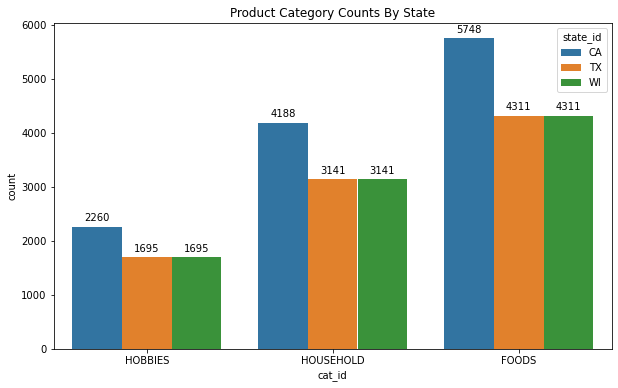

In [15]:
make_countplot("cat_id", "state_id", sales, "Product Category Counts By State", save="Figures/CatByState_Bar")

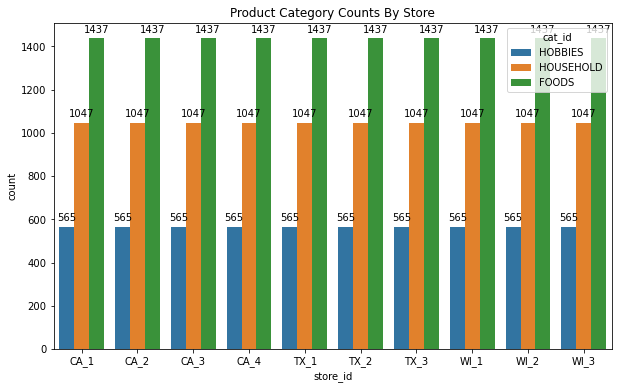

In [16]:
make_countplot("store_id", "cat_id", sales, "Product Category Counts By Store", save="Figures/CatByStore_Bar")

In [17]:
#Create arbitrary date
date = pd.to_datetime("20110101",format="%Y%m%d")
date_series = date + pd.to_timedelta(np.arange(1913), 'D')

#days list
days = [i+1 for i in range(0,1913)]

In [18]:
#function to create dataframes at various levels
def make_dataframe(data=sales, level="state", date=date):
    """state, store, category, department, product"""
    if level=="state":
        level_data = data.groupby(by="state_id").sum()
    elif level=="store":
        level_data = data.groupby(by="store_id").sum()
    elif level=="category":
        level_data = data.groupby(by="cat_id").sum()
    elif level=="department":
        level_data = data.groupby(by="dept_id").sum()
    elif level=="product":
        level_data = data.groupby(by="item_id").sum()
        
    for_column = level_data.index.to_list()
    transposed_data = np.transpose(level_data.values)
    
    df = pd.DataFrame(transposed_data, index=date, columns=for_column)
    df.index.set_names('day',inplace=True)
    return df
    
  

In [19]:
#state_sales = make_dataframe(data=sales, level="state", date=date_series)
state_sales = make_dataframe(data=sales, level="state", date=days)
store_sales = make_dataframe(data=sales, level="store", date=days)
category_sales = make_dataframe(data=sales, level="category", date=days)
department_sales = make_dataframe(data=sales, level="department", date=days)
unit_sales = make_dataframe(data=sales, level="product", date=days)

In [20]:
state_sales.head()

,CA,TX,WI
day,,,
1,14195,9438,8998
2,13805,9630,8314
3,10108,6778,6897
4,11047,7381,6984
5,9925,5912,3309


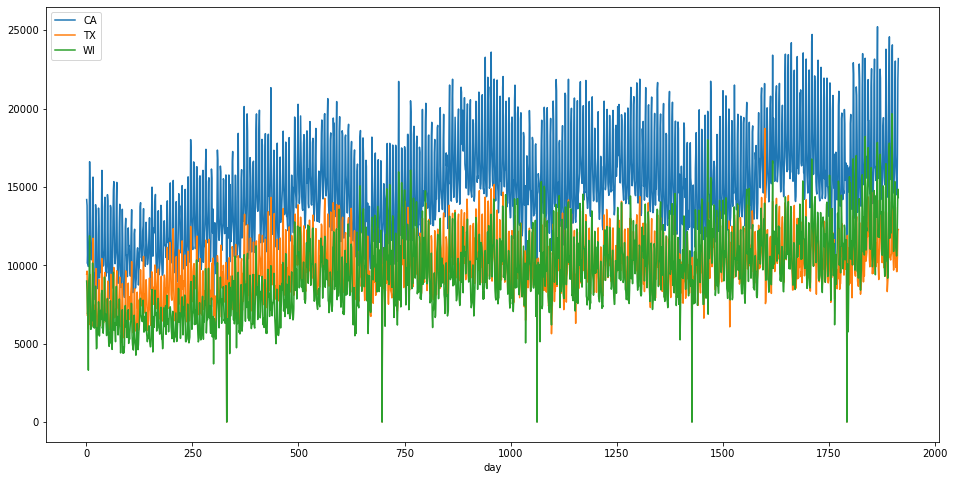

In [21]:
fig, ax = plt.subplots(figsize=(16, 8))
state_sales.plot(ax=ax)
plt.savefig("Figures/StatesJointLinePlot.png")
plt.show()

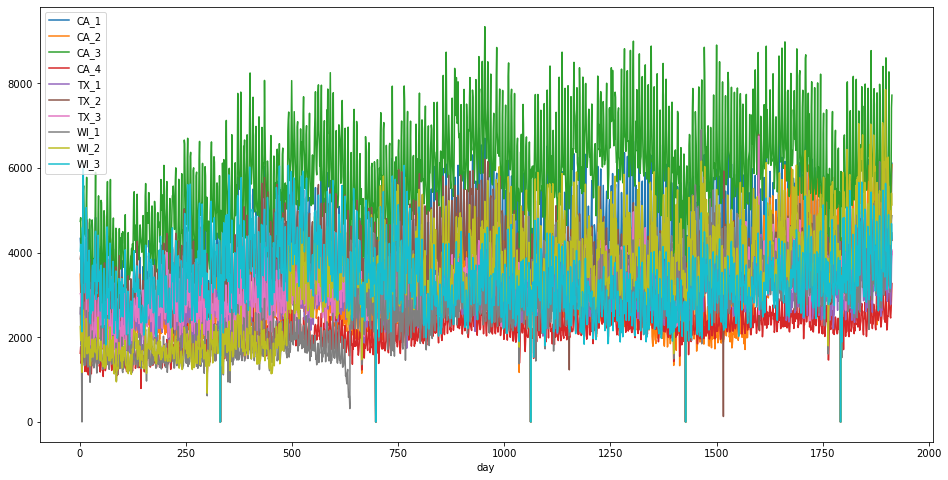

In [22]:
fig, ax = plt.subplots(figsize=(16, 8))
store_sales.plot(ax=ax)
plt.savefig("Figures/StoresJointLinePlot.png")
plt.show()

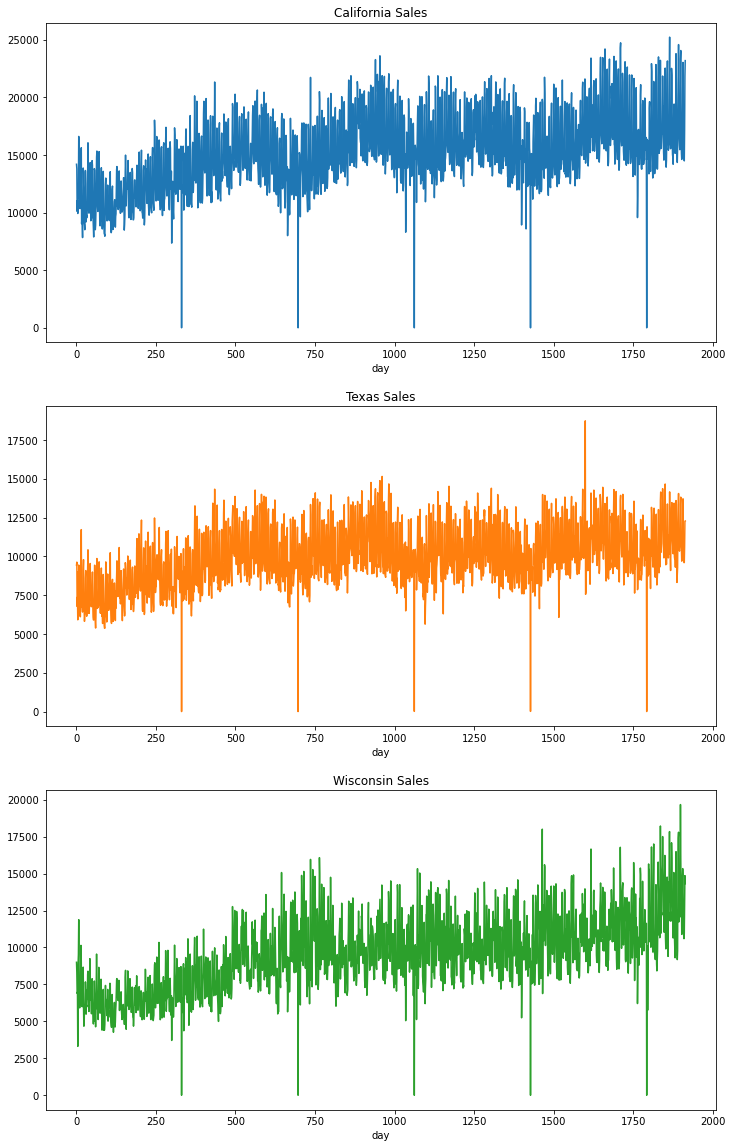

In [23]:
fig, ax = plt.subplots(3,1, figsize=(12, 20))
state_sales["CA"].plot(title="California Sales", ax=ax[0], color="tab:blue")
state_sales["TX"].plot(title="Texas Sales", ax=ax[1], color="tab:orange")
state_sales["WI"].plot(title="Wisconsin Sales",ax=ax[2], color="tab:green")
plt.savefig("Figures/StatesSeparateLinePlot.png")
plt.show()

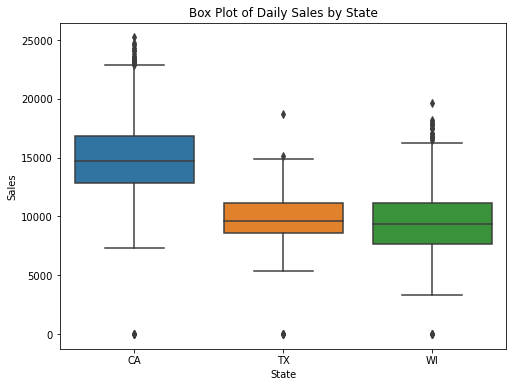

In [24]:
re_df = state_sales.reset_index()
df = pd.melt(re_df, id_vars=["day"], value_vars=state_sales.columns, var_name="State",value_name="Sales")
fig, ax0 = plt.subplots(figsize=(8, 6))
ax0 = sns.boxplot(x="State", y="Sales" ,data=df)
ax0.set_title("Box Plot of Daily Sales by State")
plt.savefig("Figures/State_Boxplot.png")
plt.show()

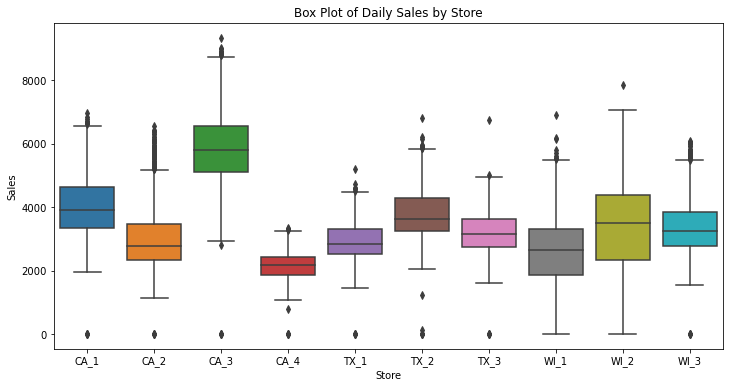

In [25]:
re_df = store_sales.reset_index()
df = pd.melt(re_df, id_vars=["day"], value_vars=store_sales.columns, var_name="Store",value_name="Sales")
fig, ax = plt.subplots(figsize=(12, 6))
ax = sns.boxplot(x="Store", y="Sales" ,data=df)
ax.set_title("Box Plot of Daily Sales by Store")
plt.savefig("Figures/Store_Boxplot.png")
plt.show()

### Focus on CA_3 Sales

In [26]:
#California Store 3 - Store Level Sales
ca3_sales = store_sales[["CA_3"]]

#California Store 3 - Product Category Level Sales
ca3_category_sales = make_dataframe(data=sales[sales.store_id=="CA_3"], level="category", date=days)

#California Store 3 - DProduct Department Level Sales
ca3_department_sales = make_dataframe(data=sales[sales.store_id=="CA_3"], level="department", date=days)

#California Store 3 - Unit Product Level Sales
ca3_unit_sales = make_dataframe(data=sales[sales.store_id=="CA_3"], level="product", date=days)

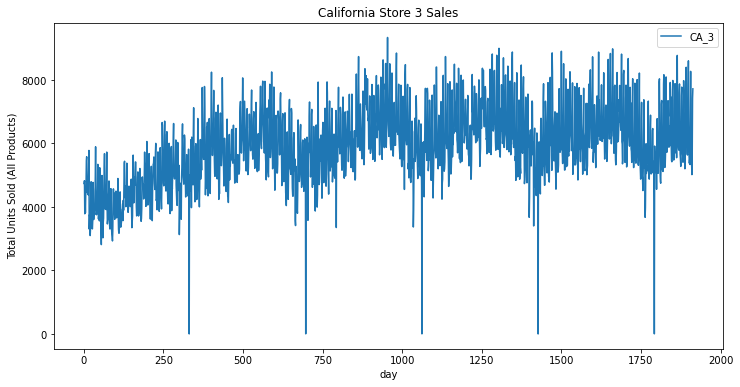

In [27]:
fig, ax = plt.subplots(figsize=(12, 6))
ca3_sales.plot(title="California Store 3 Sales", ax=ax, color="tab:blue")
plt.ylabel("Total Units Sold (All Products)")
plt.savefig("Figures/CA3SalesLinePlot.png")
plt.show()

#### Decomposition

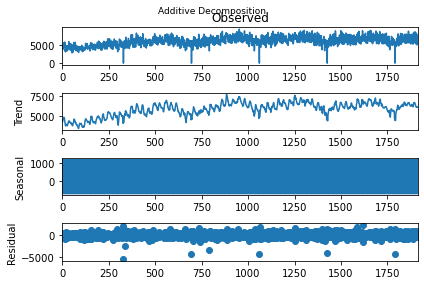

In [28]:
#Decomposition

ca3_values = ca3_sales.values
#Replace zeros with 1 for Multiplicative decompose to work
ca3_values[ca3_values == 0] = 1

add_decompose = seasonal_decompose(ca3_values, model="additive",period=7)

#fig, ax = plt.subplots(figsize=(12, 8))
add_decompose.plot().suptitle("Additive Decomposition", fontsize=9)
plt.savefig("Figures/CA3SalesAddDecomposePlot1.png")
plt.show()

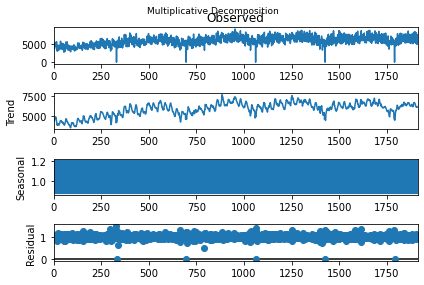

In [29]:
mul_decompose = seasonal_decompose(ca3_values, model="multiplicative",period=7)

#fig, ax = plt.subplots(figsize=(12, 8))
mul_decompose.plot().suptitle("Multiplicative Decomposition", fontsize=9)
plt.savefig("Figures/CA3SalesMultDecomposePlot1.png")
plt.show()

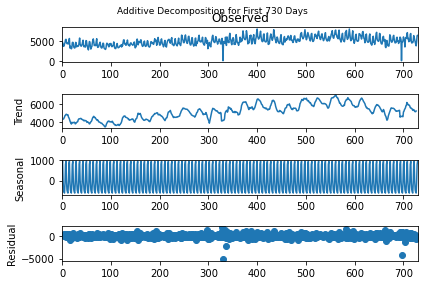

In [30]:
#First 730 Days Decomposition
ca3_values = ca3_sales.iloc[:730,].values
#Replace zeros with 1 for Multiplicative decompose to work
ca3_values[ca3_values == 0] = 1


add_decompose = seasonal_decompose(ca3_values, model="additive",period=7)

#fig, ax = plt.subplots(figsize=(12, 8))
add_decompose.plot().suptitle("Additive Decomposition for First 730 Days", fontsize=9)
plt.savefig("Figures/CA3SalesAddDecomposePlot3.png")
plt.show()

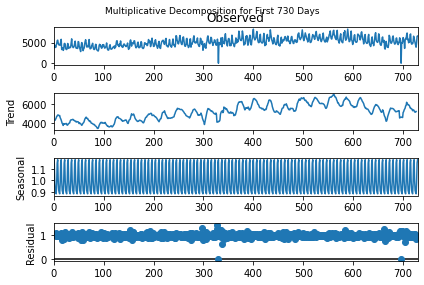

In [31]:
#First 730 Days
mul_decompose = seasonal_decompose(ca3_values, model="multiplicative",period=7)

#fig, ax = plt.subplots(figsize=(12, 8))
mul_decompose.plot().suptitle("Multiplicative Decomposition for First 730 Days", fontsize=9)
plt.savefig("Figures/CA3SalesMultDecomposePlot3.png")
plt.show()

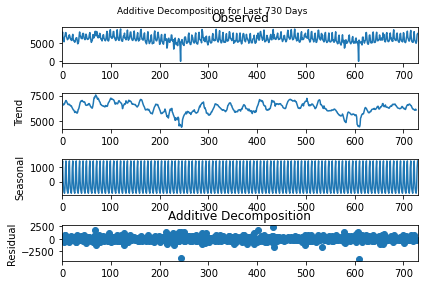

In [32]:
#Last 365 Days Decomposition
ca3_values = ca3_sales.iloc[-730:,].values
#Replace zeros with 1 for Multiplicative decompose to work
ca3_values[ca3_values == 0] = 1


add_decompose = seasonal_decompose(ca3_values, model="additive",period=7)

#fig, ax = plt.subplots(figsize=(12, 8))
add_decompose.plot().suptitle("Additive Decomposition for Last 730 Days", fontsize=9)
plt.title("Additive Decomposition")
plt.savefig("Figures/CA3SalesAddDecomposePlot2.png")
plt.show()

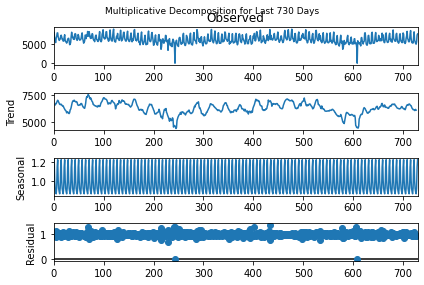

In [33]:
#Last 365 Days
mul_decompose = seasonal_decompose(ca3_values, model="multiplicative",period=7)

#fig, ax = plt.subplots(figsize=(12, 8))
mul_decompose.plot().suptitle("Multiplicative Decomposition for Last 730 Days", fontsize=9)
plt.savefig("Figures/CA3SalesMultDecomposePlot2.png")
plt.show()

#### Is the series stationary?

In [34]:
#adf test - Null hypothesis is time series is non-stationary
#kpss test - Null hypothesis is time series is stationary

def stationarity_tester(df=state_sales):
    for column in df.columns:
        # ADF Test
        print("Is the %s sales Time Series Stationary?"%(column))
        result = adfuller(df[column].values, autolag='AIC')
        print(f'ADF Statistic: {result[0]}')
        print(f'p-value: {result[1]}')
        for key, value in result[4].items():
            print('Critial Values:')
            print(f'   {key}, {value}')


        # KPSS Test
        result = kpss(df[column].values, regression='c', nlags='legacy')
        print('\nKPSS Statistic: %f' % result[0])
        print('p-value: %f' % result[1])
        for key, value in result[3].items():
            print('Critial Values:')
            print(f'   {key}, {value}')    
        print("\n")

In [35]:
#Entire Series is not stationary
stationarity_tester(df=ca3_sales)

Is the CA_3 sales Time Series Stationary?
ADF Statistic: -2.3971528976615244
p-value: 0.14254159528904403
Critial Values:
   1%, -3.433822016251123
Critial Values:
   5%, -2.8630736989499335
Critial Values:
   10%, -2.567586484303047

KPSS Statistic: 3.804115
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739




In [36]:
#First 413 days are not stationary
stationarity_tester(df=ca3_sales.iloc[:413,])

Is the CA_3 sales Time Series Stationary?
ADF Statistic: -2.0147926327128434
p-value: 0.2801249466023923
Critial Values:
   1%, -3.446845912589748
Critial Values:
   5%, -2.8688110853002007
Critial Values:
   10%, -2.5706432834592747

KPSS Statistic: 1.742358
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739




In [37]:
#Last 1500 days are stationary: No need for differencing series
stationarity_tester(df=ca3_sales.iloc[-1500:,])

Is the CA_3 sales Time Series Stationary?
ADF Statistic: -3.404242363738043
p-value: 0.010815097094019182
Critial Values:
   1%, -3.434791163965702
Critial Values:
   5%, -2.8635014840083945
Critial Values:
   10%, -2.5678142741740877

KPSS Statistic: 0.822602
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739




In [38]:
def make_acf_pacf_plots(df):
    for column in df.columns:
        fig, axes = plt.subplots(1,2,figsize=(16,5))
        #print("%s sales Time Series"%(column))
        plot_acf(df[column].tolist(), lags=50, ax=axes[0])
        plot_pacf(df[column].tolist(), lags=50, ax=axes[1])
        fig.suptitle("%s Sales Time Series"%(column), fontsize=16)
        plt.savefig("Figures/%sSalesACFPACFplots.png"%(column))

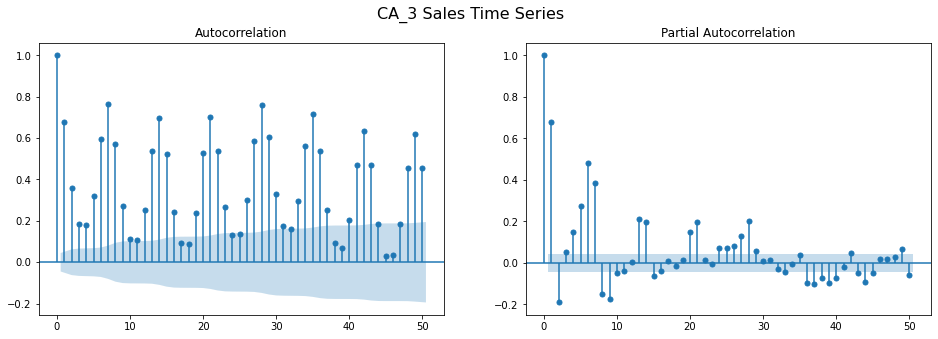

In [39]:
make_acf_pacf_plots(ca3_sales)

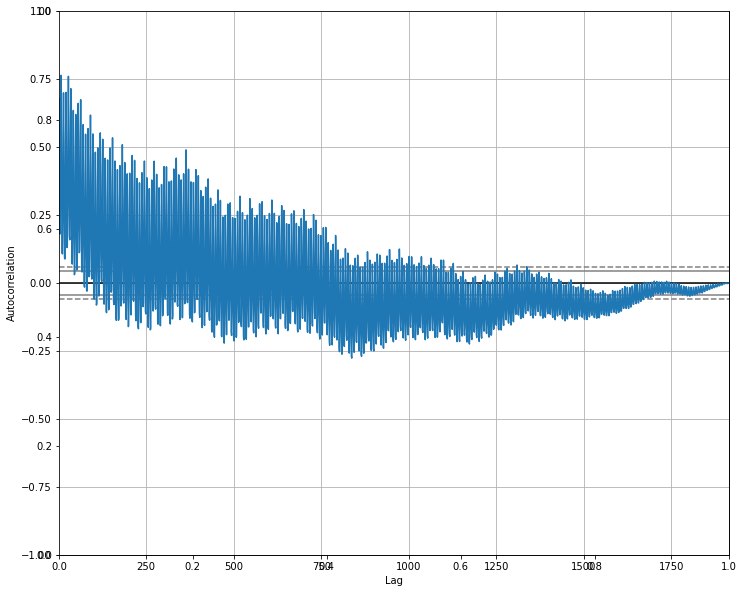

In [40]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = pd.plotting.autocorrelation_plot(ca3_sales)
plt.show()

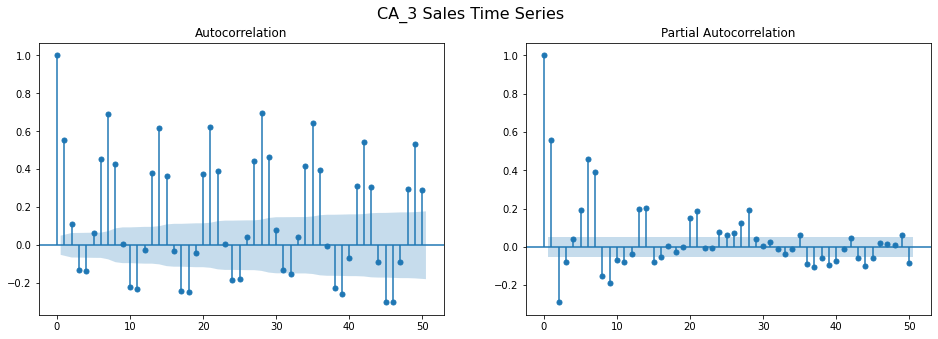

In [41]:
make_acf_pacf_plots(ca3_sales.iloc[-1500:,])

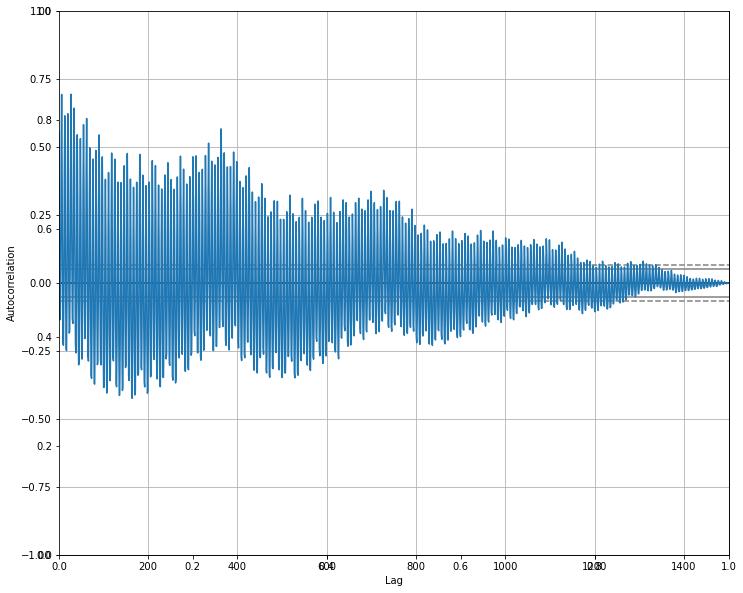

In [42]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = pd.plotting.autocorrelation_plot(ca3_sales.iloc[-1500:,])
plt.show()

## Data Modeling

In [43]:
#Model with recent statinary data
ca3_sales_recent = ca3_sales.iloc[-1500:,]
train_ca3_sales_recent = ca3_sales_recent.iloc[:-28,]
test_ca3_sales_recent = ca3_sales_recent.iloc[-28:,]

### Baseline Model - Persistence (Naive) Algorithm

In [44]:
# create lagged dataset
values = ca3_sales
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t', 't+1']
print(dataframe.head(5))

# split into train and test sets
X = dataframe.values
train_size = int(len(X) - 28)
#train_size = int(len(X) - 56)
train, test = X[1:train_size], X[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

# persistence model
def model_persistence(x):
    return x

# walk-forward validation
tr_predictions = list()
for x in train_X:
    yhat = model_persistence(x)
    tr_predictions.append(yhat)
bm_tr_mae = mean_absolute_error(train_y, tr_predictions)
print('Train MAE: %.3f' % bm_tr_mae)

# walk-forward validation
predictions = list()
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)
bm_te_mae = mean_absolute_error(test_y, predictions)
print('Test MAE: %.3f' % bm_te_mae)

          t   t+1
day              
1       NaN  4739
2    4739.0  4827
3    4827.0  3785
4    3785.0  4232
5    4232.0  3817
Train MAE: 704.120
Test MAE: 849.107


### ARIMA Model

In [45]:
def find_optimal_arima(ts, p, q):
    bicList = []
    pqtuple = []
    for pval in p:
        for qval in q:
            model = SARIMAX(ts, order=(pval,0,qval))
            result = model.fit()
            bicList.append(result.bic)
            pqtuple.append((pval,0,qval))
    minbic = min(bicList)
    index = bicList.index(minbic)
    print("Best Model --> ARIMA%s"%(pqtuple[index],))

In [46]:
random.seed(49)

find_optimal_arima(train_ca3_sales_recent.CA_3, [0,1,2,3,4,5,6,7], [0,1,2,3,4,5,6,7])

Best Model --> ARIMA(6, 0, 7)


In [47]:
random.seed(49)

#train data
arima_mod = SARIMAX(train_ca3_sales_recent.CA_3, order=(6,0,7))
arima_result = arima_mod.fit()
print(arima_result.summary())

                               SARIMAX Results                                
Dep. Variable:                   CA_3   No. Observations:                 1472
Model:               SARIMAX(6, 0, 7)   Log Likelihood              -11516.930
Date:                Fri, 19 Mar 2021   AIC                          23061.860
Time:                        09:58:25   BIC                          23135.982
Sample:                             0   HQIC                         23089.499
                               - 1472                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8531      0.121      7.042      0.000       0.616       1.091
ar.L2         -0.5348      0.219     -2.447      0.014      -0.963      -0.106
ar.L3          0.1120      0.273      0.410      0.6

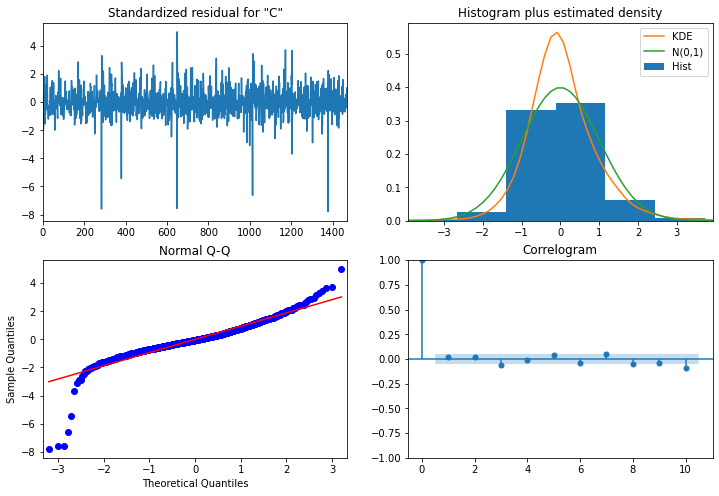

In [48]:
#Snip plots
arima_result.plot_diagnostics(figsize=(12,8))
plt.show()

In [49]:
#residuals on train data
arima_result.resid.describe()

count    1472.000000
mean        6.340895
std       627.290265
min     -4966.409003
25%      -315.680869
50%       -32.114840
75%       292.388696
max      6773.000000
dtype: float64

In [50]:
#save arima train mean absolute error (mae) (residuals)
arima_residuals = arima_result.resid
arima_residuals = arima_residuals.values
arima_tr_mae = np.mean(np.absolute(arima_residuals))
arima_tr_mae

419.3789169179773

In [51]:
#test model
test_prediction = arima_result.get_forecast(steps=28).predicted_mean
arima_te_mae = mean_absolute_error(test_ca3_sales_recent.values, test_prediction)
arima_te_mae

403.6238462465205

In [52]:
#refit on entire relevant dataset for forecast
arima_mod = SARIMAX(ca3_sales_recent.CA_3, order=(6,0,7))
arima_result = arima_mod.fit()
arima_forecast = arima_result.get_forecast(steps=28).predicted_mean


In [53]:
#residuals on entire relevant data
arima_result.resid.describe()

count    1500.000000
mean        5.797559
std       624.209410
min     -4915.814170
25%      -307.662032
50%       -27.531374
75%       300.524654
max      6773.000000
dtype: float64

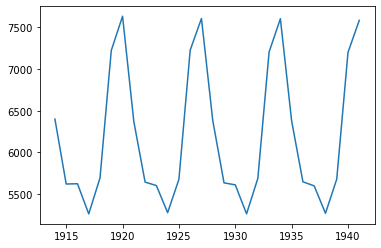

In [54]:
forecast_days = [max(days)+i for i in range(1,29)]

plt.plot(forecast_days, arima_forecast)
plt.show()

### SARIMA Model

In [55]:
def find_optimal_sarima(ts, p, q):
    bicList = []
    pqtuple = []
    for pval in p:
        for qval in q:
            model = SARIMAX(ts, order=(0,0,0),seasonal_order=(pval,1,qval,7))
            result = model.fit()
            bicList.append(result.bic)
            pqtuple.append((pval,1,qval,7))
    minbic = min(bicList)
    index = bicList.index(minbic)
    print("Best Model --> SARIMA(0,0,0)%s"%(pqtuple[index],))

In [56]:
random.seed(49)

find_optimal_sarima(train_ca3_sales_recent.CA_3, [0,1,2,3,4,5,6,7], [0,1,2,3,4,5,6,7])

Best Model --> SARIMA(0,0,0)(5, 1, 6, 7)


In [57]:
random.seed(49)

sarima_mod = SARIMAX(train_ca3_sales_recent.CA_3, order=(0,0,0), seasonal_order=(6,1,6,7))
sarima_result = sarima_mod.fit()
print(sarima_result.summary())

                                        SARIMAX Results                                         
Dep. Variable:                                     CA_3   No. Observations:                 1472
Model:             SARIMAX(6, 1, [1, 2, 3, 4, 5, 6], 7)   Log Likelihood              -11503.305
Date:                                  Fri, 19 Mar 2021   AIC                          23032.610
Time:                                          10:22:08   BIC                          23101.375
Sample:                                               0   HQIC                         23058.258
                                                 - 1472                                         
Covariance Type:                                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7       -0.5555      0.074     -7.522      0.000      -0.700

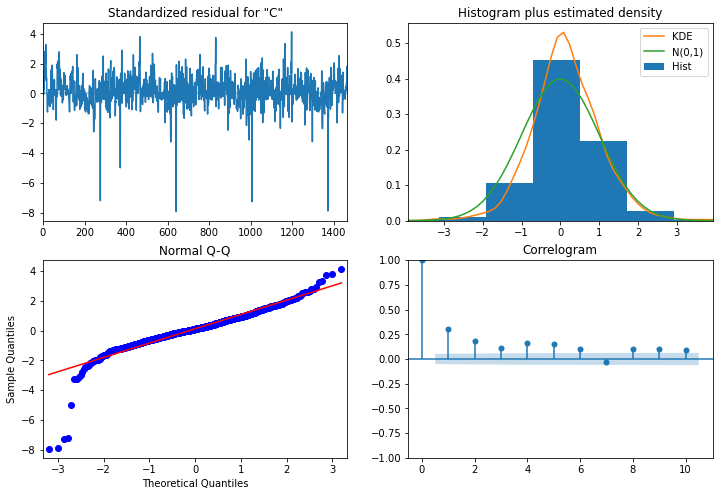

In [58]:
#Snip plots
sarima_result.plot_diagnostics(figsize=(12,8))
plt.show()

In [59]:
#residuals on train data
sarima_result.resid.describe()

count    1472.000000
mean      104.189872
std       725.851789
min     -5061.083713
25%      -243.828936
50%        63.901392
75%       438.878507
max      6983.000000
dtype: float64

In [60]:
#save train sarima mean absolute error (mae) (residuals)
sarima_residuals = sarima_result.resid
sarima_residuals = sarima_residuals.values
sarima_tr_mae = np.mean(np.absolute(sarima_residuals))
sarima_tr_mae

461.72483274582953

In [61]:
#test model
test_sarima_prediction = sarima_result.get_forecast(steps=28).predicted_mean
sarima_te_mae = mean_absolute_error(test_ca3_sales_recent.values, test_sarima_prediction)
sarima_te_mae

271.3317731731438

In [62]:
#refit for forecast
sarima_mod = SARIMAX(ca3_sales_recent.CA_3, order=(0,0,0), seasonal_order=(6,1,6,7))
sarima_result = sarima_mod.fit()
sarima_forecast = sarima_result.get_forecast(steps=28).predicted_mean

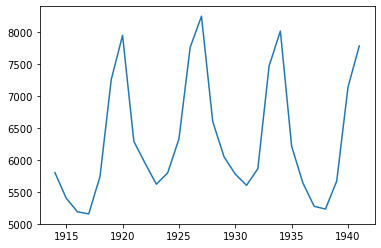

In [63]:
plt.plot(forecast_days, sarima_forecast)
plt.show()

### Random Forest Regressor

In [64]:
def make_Xy_df(data, n_in=1, n_out=1, dropnan=True):
    df = pd.DataFrame(data)
    cols = []
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = pd.concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan==True:
        agg.dropna(inplace=True)
    elif dropnan==False: 
        agg.fillna(method='bfill',inplace=True)
    #return numpy array data where the last column is the target (original series)
    return agg.values

In [65]:
#Time Series with 7 Shifts as features
CA3_withShifts = make_Xy_df(ca3_sales, n_in=7)

In [66]:
CA3_withShifts[:5]

array([[4739., 4827., 3785., 4232., 3817., 4369., 4703., 5456.],
       [4827., 3785., 4232., 3817., 4369., 4703., 5456., 5581.],
       [3785., 4232., 3817., 4369., 4703., 5456., 5581., 4912.],
       [4232., 3817., 4369., 4703., 5456., 5581., 4912., 4447.],
       [3817., 4369., 4703., 5456., 5581., 4912., 4447., 4544.]])

In [67]:
ca3_sales.head(10)

,CA_3
day,
1,4739
2,4827
3,3785
4,4232
5,3817
6,4369
7,4703
8,5456
9,5581


In [68]:
def find_optimal_rfr_param(X_array,y_array,max_feat=4,md_max=100):
    """for max_depth_max (md_max), choose an integer between 50 and 150.
    for max_features (max_feat), choose the mean number of features"""
    X = X_array
    y= y_array
    tscv = TimeSeriesSplit(n_splits=5)
    max_depth =[]
    score = []
    for tr_index, val_index in tscv.split(X):
        X_tr, X_val = X[tr_index],X[val_index]
        y_tr, y_val = y[tr_index], y[val_index]
        for md in np.arange(50, md_max):
            rfr = RandomForestRegressor(max_features=max_feat,max_depth=md,random_state=49)
            rfr.fit(X_tr, y_tr)
            prediction = rfr.predict(X_val)
            max_depth.append(md)
            score.append(mean_absolute_error(y_val,prediction))

    minscore = min(score)
    index = score.index(minscore)
    print("Best params: (max_depth,max_features) --> (%.0f,%.0f)"%(max_depth[index],max_feat)) #50

In [69]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]


# fit an random forest model and make a one step prediction
def model_forecast(train, testX, model):
    """ model=RandomForestRegressor(max_features=4,max_depth=130)"""
    # transform list into array
    train = np.asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict([testX])
    return yhat[0]


# walk-forward validation for univariate data
def foreward_stepwise_forecast(data, n_test, model):
    predictions = []
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history and make a prediction
        yhat = model_forecast(history, testX,model)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    #return predictions
    return predictions

In [70]:
def find_rfr_mae(X_array,y_array,max_feat=4,md_max=100):
    """for max_depth_max (md_max), choose an integer between 50 and 150.
    for max_features (max_feat), choose the mean number of features"""
    X = X_array
    y= y_array
    tscv = TimeSeriesSplit(n_splits=5)
    max_depth =[]
    score = []
    for tr_index, val_index in tscv.split(X):
        X_tr, X_val = X[tr_index],X[val_index]
        y_tr, y_val = y[tr_index], y[val_index]
        rfr = RandomForestRegressor(max_features=max_feat,max_depth=md_max,random_state=49)
        rfr.fit(X_tr, y_tr)
        prediction = rfr.predict(X_val)
        score.append(mean_absolute_error(y_val,prediction))

    #meanscore = np.mean(np.asarray(score))
    meanscore = hmean(np.asarray(score))
    return meanscore

In [71]:
complete_X = CA3_withShifts[:,:-1]
complete_y = CA3_withShifts[:,-1]

train_data = CA3_withShifts[:-28,:]
train_X = CA3_withShifts[:-28,:-1]
train_y = CA3_withShifts[:-28,-1]

test_X = CA3_withShifts[-28:,:-1]
test_y = CA3_withShifts[-28:,-1]

In [72]:
complete_X.shape, train_X.shape, test_X.shape

((1906, 7), (1878, 7), (28, 7))

In [73]:
#find optimal parameter using complete data
random.seed(49) 

find_optimal_rfr_param(CA3_withShifts[:,:-1], CA3_withShifts[:,-1],max_feat=4,md_max=150)

Best params: (max_depth,max_features) --> (50,4)


In [74]:
#find optimal parameter using train data
random.seed(49) 

find_optimal_rfr_param(train_X, train_y,max_feat=4,md_max=150)

Best params: (max_depth,max_features) --> (50,4)


In [75]:
random.seed(49)

#Find mean absolute error on train data
rfr_tr_mae = find_rfr_mae(train_X, train_y,max_feat=4,md_max=50)
rfr_tr_mae

476.8700499196087

In [76]:
#Find mean absolute error on test data
random.seed(49)

test_prediction = foreward_stepwise_forecast(train_data, 28,RandomForestRegressor(max_features=4,max_depth=50,random_state=49))
rfr_te_mae = mean_absolute_error(test_y, test_prediction)
rfr_te_mae

297.02571428571434

In [77]:
#Forecast using the entire dataset
ml_data = make_Xy_df(ca3_sales, n_in=7, n_out=1, dropnan=True)

random.seed(49)

rfr_forecast = foreward_stepwise_forecast(ml_data, 28,RandomForestRegressor(max_features=4,max_depth=50,random_state=49))

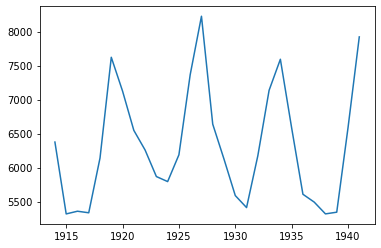

In [78]:
plt.plot(forecast_days, rfr_forecast)
plt.show()

### K-Nearest Neighbors Regressor

In [79]:
def find_optimal_knn_param(X_array,y_array,max_nn=30):
    """for max_neighbors choose an integer between 1 and 60."""
    X = X_array
    y= y_array
    tscv = TimeSeriesSplit(n_splits=5)
    max_neighbors =[]
    score = []
    for tr_index, val_index in tscv.split(X):
        X_tr, X_val = X[tr_index],X[val_index]
        y_tr, y_val = y[tr_index], y[val_index]
        for n in np.arange(1, max_nn+1):
            knn = KNN(n_neighbors=n)
            knn.fit(X_tr, y_tr)
            prediction = knn.predict(X_val)
            max_neighbors.append(n)
            score.append(mean_absolute_error(y_val,prediction))

    minscore = min(score)
    index = score.index(minscore)
    print("Best params: n_neighbors --> (%.0f)"%(max_neighbors[index])) #7

In [80]:
def find_knn_mae(X_array,y_array,n=7):
    """for max_neighbors choose an integer between 1 and 60."""
    X = X_array
    y= y_array
    tscv = TimeSeriesSplit(n_splits=5)
    max_neighbors =[]
    score = []
    for tr_index, val_index in tscv.split(X):
        X_tr, X_val = X[tr_index],X[val_index]
        y_tr, y_val = y[tr_index], y[val_index]
        knn = KNN(n_neighbors=n)
        knn.fit(X_tr, y_tr)
        prediction = knn.predict(X_val)
        max_neighbors.append(n)
        score.append(mean_absolute_error(y_val,prediction))

    #meanscore = np.mean(np.asarray(score))
    meanscore = hmean(np.asarray(score))
    return meanscore

In [81]:
#find optimal parameter on entire data
random_state=49

find_optimal_knn_param(CA3_withShifts[:,:-1], CA3_withShifts[:,-1],max_nn=30)

Best params: n_neighbors --> (7)


In [82]:
#find optimal parameter on train data
random_state=49

find_optimal_knn_param(train_X, train_y,max_nn=30)

Best params: n_neighbors --> (7)


In [83]:
#Find mae on train data
knn_tr_mae = find_knn_mae(train_X, train_y,n=7)
knn_tr_mae

494.5457376547478

In [84]:
#Find mean absolute error on test data

knn_test_prediction = foreward_stepwise_forecast(train_data, 28,KNN(n_neighbors=7))
knn_te_mae = mean_absolute_error(test_y, knn_test_prediction)
knn_te_mae

258.1224489795918

In [85]:
#Forecast
ml_data = make_Xy_df(ca3_sales, n_in=7, n_out=1, dropnan=True)
knn_forecast = foreward_stepwise_forecast(ml_data, 28,KNN(n_neighbors=7))

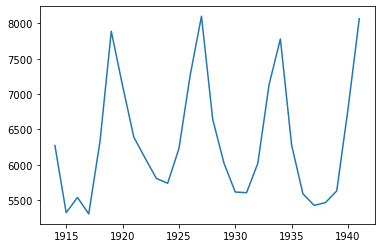

In [86]:
plt.plot(forecast_days, knn_forecast)
plt.show()

### Conclusion

In [87]:
forecast_df = pd.DataFrame(np.round(arima_forecast.values), index=forecast_days, columns=["arima_forecast"])
forecast_df["sarima_forecast"] = np.round(sarima_forecast.values)
forecast_df["rfr_forecast"] = np.round(rfr_forecast)
forecast_df["knn_forecast"] = np.round(knn_forecast)

In [88]:
forecast_df

,arima_forecast,sarima_forecast,rfr_forecast,knn_forecast
1914,6399.0,5798.0,6376.0,6272.0
1915,5622.0,5399.0,5320.0,5323.0
1916,5625.0,5185.0,5359.0,5538.0
1917,5264.0,5152.0,5336.0,5305.0
1918,5695.0,5737.0,6141.0,6332.0
1919,7221.0,7255.0,7623.0,7889.0
1920,7631.0,7944.0,7126.0,7119.0
1921,6370.0,6287.0,6548.0,6391.0
1922,5645.0,5944.0,6259.0,6094.0
1923,5603.0,5617.0,5869.0,5808.0


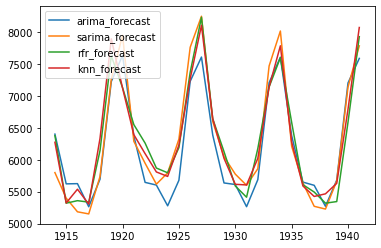

In [89]:
forecast_df.plot()
plt.show()

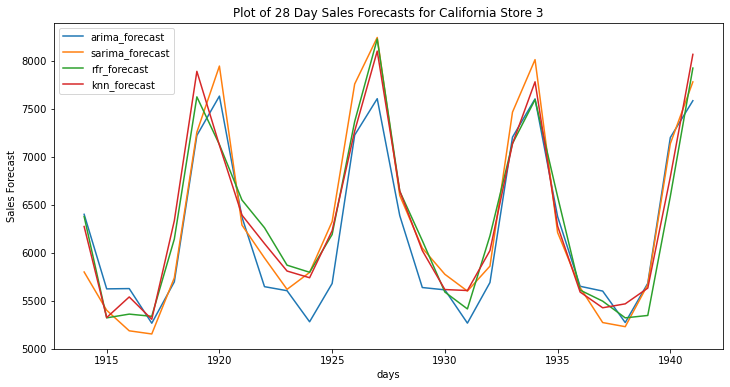

In [90]:
fig, ax = plt.subplots(figsize=(12, 6))
forecast_df.plot(ax=ax)
plt.xlabel("days")
plt.ylabel("Sales Forecast")
plt.title("Plot of 28 Day Sales Forecasts for California Store 3")
plt.savefig("Figures/AllForecastsPlot1.png")
plt.show()

The 28-day forecasts of the four models have the same shape and collectively emphasize the seven day seasonality of the time series. 

In [91]:
ca3_sales_withForecast = ca3_sales.append(forecast_df)

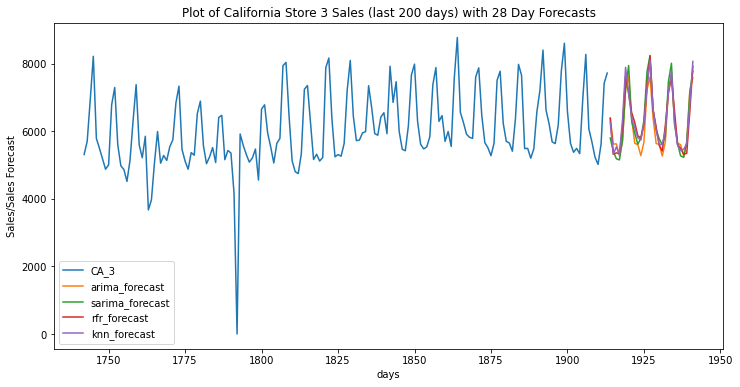

In [92]:
fig, ax = plt.subplots(figsize=(12, 6))
ca3_sales_withForecast.iloc[-200:].plot(ax=ax)
plt.xlabel("days")
plt.ylabel("Sales/Sales Forecast")
plt.title("Plot of California Store 3 Sales (last 200 days) with 28 Day Forecasts")
plt.savefig("Figures/SalesWithForecastsPlot1.png")
plt.show()

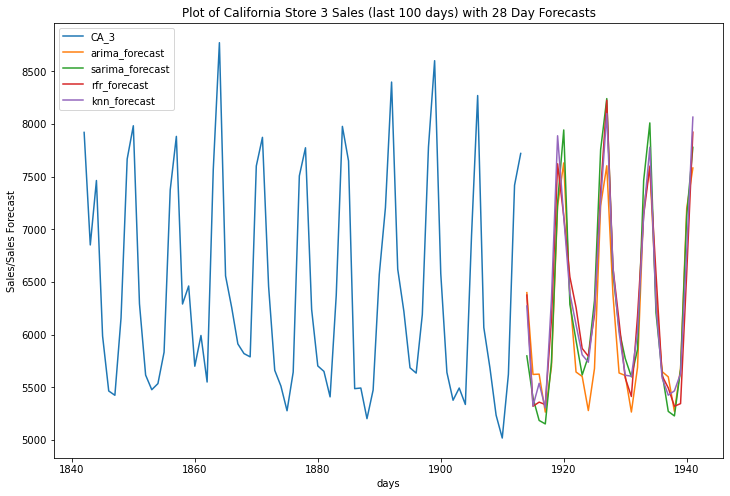

In [93]:
fig, ax = plt.subplots(figsize=(12, 8))
ca3_sales_withForecast.iloc[-100:].plot(ax=ax)
plt.xlabel("days")
plt.ylabel("Sales/Sales Forecast")
plt.title("Plot of California Store 3 Sales (last 100 days) with 28 Day Forecasts")
plt.savefig("Figures/SalesWithForecastsPlot2.png")
plt.show()

In [94]:
#Train MAEs
mae_tr_dict = {"bm_tr_mae":bm_tr_mae,"arima_tr_mae":arima_tr_mae, "sarima_tr_mae":sarima_tr_mae, "rfr_tr_mae":rfr_tr_mae, "knn_tr_mae": knn_tr_mae}

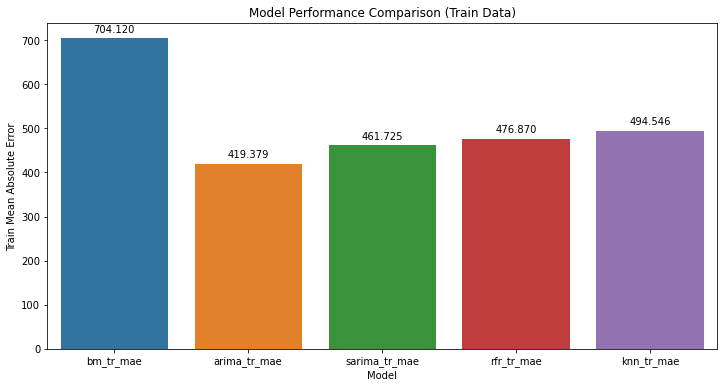

In [95]:
fig, ax = plt.subplots(figsize=(12, 6))
ax=sns.barplot(x=list(mae_tr_dict.keys()), y=list(mae_tr_dict.values()))
plt.xticks(range(len(mae_tr_dict)), list(mae_tr_dict.keys()))
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.3f'), (p.get_x() + p.get_width()/2., p.get_height()), ha = "center", va = "center", xytext= (0,9), textcoords ="offset points")
plt.xlabel("Model")
plt.ylabel("Train Mean Absolute Error")
plt.title("Model Performance Comparison (Train Data)")
plt.savefig("Figures/TrainMAEPlot.png")
plt.show()

In [96]:
#Test MAEs
mae_te_dict = {"bm_te_mae":bm_te_mae, "arima_te_mae":arima_te_mae, "sarima_te_mae":sarima_te_mae, "rfr_te_mae":rfr_te_mae, "knn_te_mae": knn_te_mae}

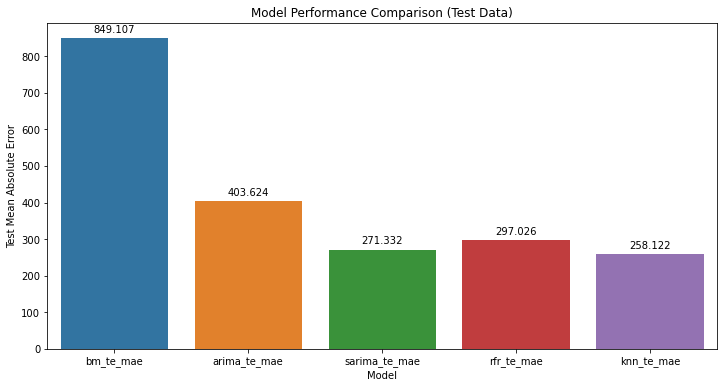

In [97]:
fig, ax = plt.subplots(figsize=(12, 6))
ax=sns.barplot(x=list(mae_te_dict.keys()), y=list(mae_te_dict.values()))
plt.xticks(range(len(mae_te_dict)), list(mae_te_dict.keys()))
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.3f'), (p.get_x() + p.get_width()/2., p.get_height()), ha = "center", va = "center", xytext= (0,9), textcoords ="offset points")
plt.xlabel("Model")
plt.ylabel("Test Mean Absolute Error")
plt.title("Model Performance Comparison (Test Data)")
plt.savefig("Figures/TestMAEPlot.png")
plt.show()

Comparatively, all the models produced similar 28 day sales forecasts. If we base the choice of an ideal model on interpretability and model parsimony, the ARIMA(6,0,7) model stands out. 

It is noteworthy that all the four major models performed better than the Baseline model. 
Based on the mean absolute error on the test data, the K-Nearest Neighbors (k=7) model is the best model. The ARIMA(6,0,7) model has the highest error value among the four models.
If we base the choice of an ideal model on interpretability and model parsimony, the SARIMA(0,0,0)(6,1,6)7 model should be selected.

In [98]:
forecast_new_index = ["d_"+ str(n) for n in forecast_df.index.tolist()]

In [99]:
forecast_df.index = forecast_new_index

In [100]:
forecast_df.index

Index(['d_1914', 'd_1915', 'd_1916', 'd_1917', 'd_1918', 'd_1919', 'd_1920',
       'd_1921', 'd_1922', 'd_1923', 'd_1924', 'd_1925', 'd_1926', 'd_1927',
       'd_1928', 'd_1929', 'd_1930', 'd_1931', 'd_1932', 'd_1933', 'd_1934',
       'd_1935', 'd_1936', 'd_1937', 'd_1938', 'd_1939', 'd_1940', 'd_1941'],
      dtype='object')

In [101]:
forecast_df.to_csv("Forecasts/28DayForecasts.csv")

In [102]:
all_new_index = ["d_"+ str(n) for n in ca3_sales_withForecast.index.tolist()]

In [103]:
ca3_sales_withForecast.index = all_new_index

In [104]:
ca3_sales_withForecast.tail()

,CA_3,arima_forecast,sarima_forecast,rfr_forecast,knn_forecast
d_1937,NaN,5599.0,5271.0,5494.0,5425.0
d_1938,NaN,5271.0,5228.0,5320.0,5466.0
d_1939,NaN,5680.0,5666.0,5345.0,5630.0
d_1940,NaN,7199.0,7135.0,6586.0,6788.0
d_1941,NaN,7583.0,7779.0,7923.0,8066.0


In [105]:
ca3_sales_withForecast.to_csv("Forecasts/SalesWithForecasts.csv")

### References

Kaggle. (2020, June 01). M5 forecasting - Accuracy. Retrieved February 01, 2021, from https://www.kaggle.com/c/m5-forecasting-accuracy

Brownlee, J. (2017). Introduction to time series forecasting with Python: How to prepare data and develop models to predict the future. Jason Brownlee.

Vishwas, B. V., & PATEL, A. (2020). Hands-on Time Series Analysis with Python From Basics to Bleeding Edge Techniques. Berkeley, CA: Apress.